# NBA Foul Analysis with Item Response Theory

This notebook demonstrates Bayesian Item Response Theory applied to NBA foul calls data using PyMC. Inspired by Austin Rochford’s blogpost and adapted by Lorenzo Toniazzi.

In [6]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

%matplotlib inline
print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Running on PyMC v5.12.0


## Introduction

We analyze binary outcomes (foul called or not) from NBA plays, modeling the latent abilities of players as committing or disadvantaged agents. Bayesian Item Response Theory and the Rasch model allow us to estimate these abilities and explore hierarchical structures.

## Data Collection and Processing

We use NBA Last Two Minutes Reports (2015-2021). Each row is a play involving two players. We process the data to create binary variables and assign player IDs.

In [7]:
try:
    df_orig = pd.read_csv("/home/gabriel/Escritorio/Proyectos/Proyectos_datos/Magister/analisis-calidad-estimacion-1pl-bayesiana/data/01_raw/example_data_pymc/item_response_nba.csv", index_col=0)
except FileNotFoundError:
    raise FileNotFoundError("El archivo de datos no se encuentra en la ruta local especificada.")
df_orig.head()

,committing,disadvantaged,decision,committing_position,disadvantaged_position
play_id,,,,,
1,Avery Bradley,Stephen Curry,CNC,G,G
3,Isaiah Thomas,Andre Iguodala,CNC,G,G-F
4,Jae Crowder,Harrison Barnes,INC,F,F
6,Draymond Green,Isaiah Thomas,CC,F,G
7,Avery Bradley,Stephen Curry,CC,G,G


**Nota:** En este notebook, la data se carga desde la ruta local `data/01_raw/example_data_pymc/item_response_nba.csv` siguiendo la estructura del proyecto Kedro. Asegúrate de que el archivo esté disponible en esa ubicación antes de ejecutar la celda de carga de datos.

In [8]:
# 1. Construct df and df_position
df = df_orig[["committing", "disadvantaged", "decision"]]

df_position = pd.concat(
    [
        df_orig.groupby("committing").committing_position.first(),
        df_orig.groupby("disadvantaged").disadvantaged_position.first(),
    ]
).to_frame()
df_position = df_position[~df_position.index.duplicated(keep="first")]
df_position.index.name = "player"
df_position.columns = ["position"]

# 2. Create the binary foul_called variable
def foul_called(decision):
    out = 0
    if (decision == "CC") | (decision == "IC"):
        out = 1
    return out

df = df.assign(foul_called=lambda df: df["decision"].apply(foul_called))

# 3. Index observed calls by committing and disadvantaged players
committing_observed, committing = pd.factorize(df.committing, sort=True)
disadvantaged_observed, disadvantaged = pd.factorize(df.disadvantaged, sort=True)
df.index.name = "play_id"

print(f"Number of observed plays: {len(df)}")
print(f"Number of disadvantaged players: {len(disadvantaged)}")
print(f"Number of committing players: {len(committing)}")
print(f"Global probability of a foul being called: {100*round(df.foul_called.mean(),3)}%\n\n")
df.head()

Number of observed plays: 46861
Number of disadvantaged players: 770
Number of committing players: 789
Global probability of a foul being called: 23.3%




,committing,disadvantaged,decision,foul_called
play_id,,,,
1,Avery Bradley,Stephen Curry,CNC,0
3,Isaiah Thomas,Andre Iguodala,CNC,0
4,Jae Crowder,Harrison Barnes,INC,0
6,Draymond Green,Isaiah Thomas,CC,1
7,Avery Bradley,Stephen Curry,CC,1


## Item Response Model

We use a Rasch model to estimate latent skills for each player. The model features partial pooling via hierarchical hyperpriors.

In [9]:
coords = {"disadvantaged": disadvantaged, "committing": committing}

with pm.Model(coords=coords) as model:
    # Data
    foul_called_observed = pm.Data("foul_called_observed", df.foul_called, mutable=False)

    # Hyperpriors
    mu_theta = pm.Normal("mu_theta", 0.0, 100.0)
    sigma_theta = pm.HalfCauchy("sigma_theta", 2.5)
    sigma_b = pm.HalfCauchy("sigma_b", 2.5)

    # Priors
    Delta_theta = pm.Normal("Delta_theta", 0.0, 1.0, dims="disadvantaged")
    Delta_b = pm.Normal("Delta_b", 0.0, 1.0, dims="committing")

    # Deterministic
    theta = pm.Deterministic("theta", Delta_theta * sigma_theta + mu_theta, dims="disadvantaged")
    b = pm.Deterministic("b", Delta_b * sigma_b, dims="committing")
    eta = pm.Deterministic("eta", theta[disadvantaged_observed] - b[committing_observed])

    # Likelihood
    y = pm.Bernoulli("y", logit_p=eta, observed=foul_called_observed)

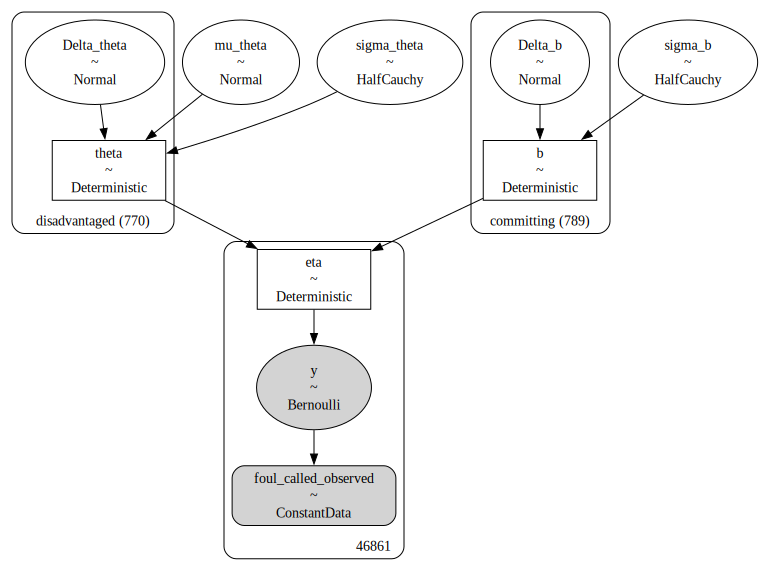

In [10]:
pm.model_to_graphviz(model)

## Sampling and Convergence

We sample from the Rasch model and check convergence.

In [11]:
with model:
    trace = pm.sample(1000, tune=1500, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_theta, sigma_theta, sigma_b, Delta_theta, Delta_b]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 145 seconds.


<Axes: >

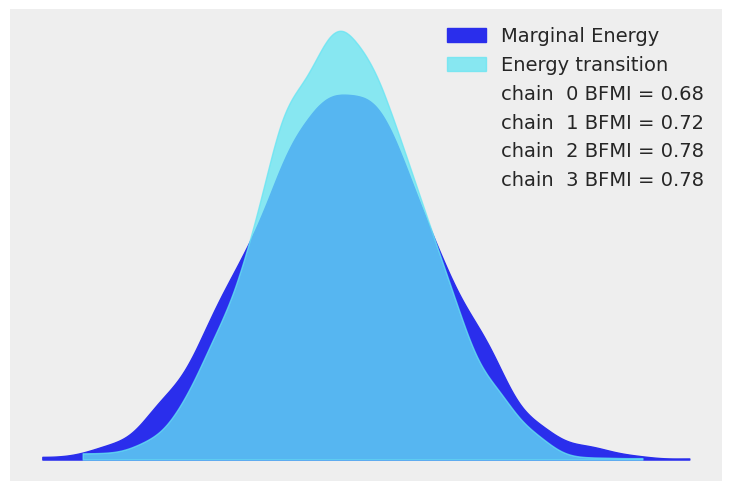

In [12]:
az.plot_energy(trace)

## Posterior Analysis

We visualize partial pooling and rank players by their estimated skills.

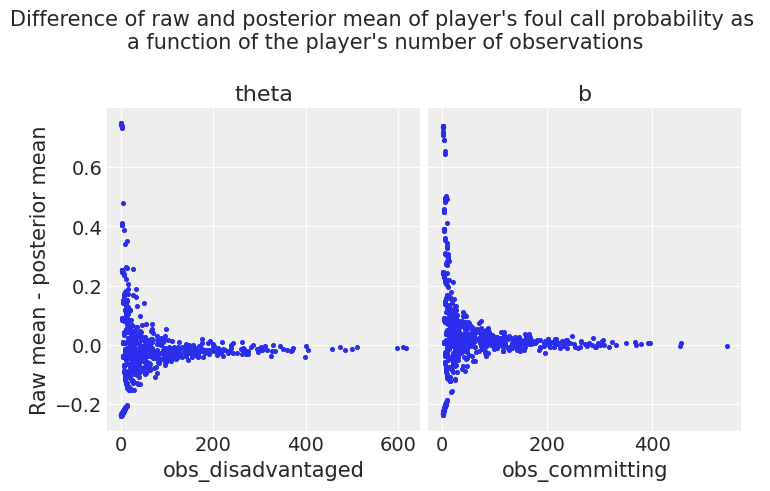

In [13]:
mu_theta_mean, mu_b_mean = trace.posterior["mu_theta"].mean(), 0
disadvantaged_raw_mean = df.groupby("disadvantaged")["foul_called"].mean()
committing_raw_mean = df.groupby("committing")["foul_called"].mean()
disadvantaged_posterior_mean = (
    1 / (1 + np.exp(-trace.posterior["theta"].mean(dim=["chain", "draw"]))).to_pandas()
)
committing_posterior_mean = (
    1 / (1 + np.exp(-(mu_theta_mean - trace.posterior["b"].mean(dim=["chain", "draw"]))).to_pandas())
)

def diff(a, b):
    return a - b

df_disadvantaged = pd.DataFrame(
    disadvantaged_raw_mean.combine(disadvantaged_posterior_mean, diff),
    columns=["Raw - posterior mean"],
)
df_committing = pd.DataFrame(
    committing_raw_mean.combine(committing_posterior_mean, diff), columns=["Raw - posterior mean"]
)
df_disadvantaged = df_disadvantaged.assign(obs_disadvantaged=df["disadvantaged"].value_counts())
df_committing = df_committing.assign(obs_committing=df["committing"].value_counts())

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle(
    "Difference of raw and posterior mean of player's foul call probability as "
    "\na function of the player's number of observations\n",
    fontsize=15,
)
ax1.scatter(data=df_disadvantaged, x="obs_disadvantaged", y="Raw - posterior mean", s=7, marker="o")
ax1.set_title("theta")
ax1.set_ylabel("Raw mean - posterior mean")
ax1.set_xlabel("obs_disadvantaged")
ax2.scatter(data=df_committing, x="obs_committing", y="Raw - posterior mean", s=7)
ax2.set_title("b")
ax2.set_xlabel("obs_committing")
plt.show()

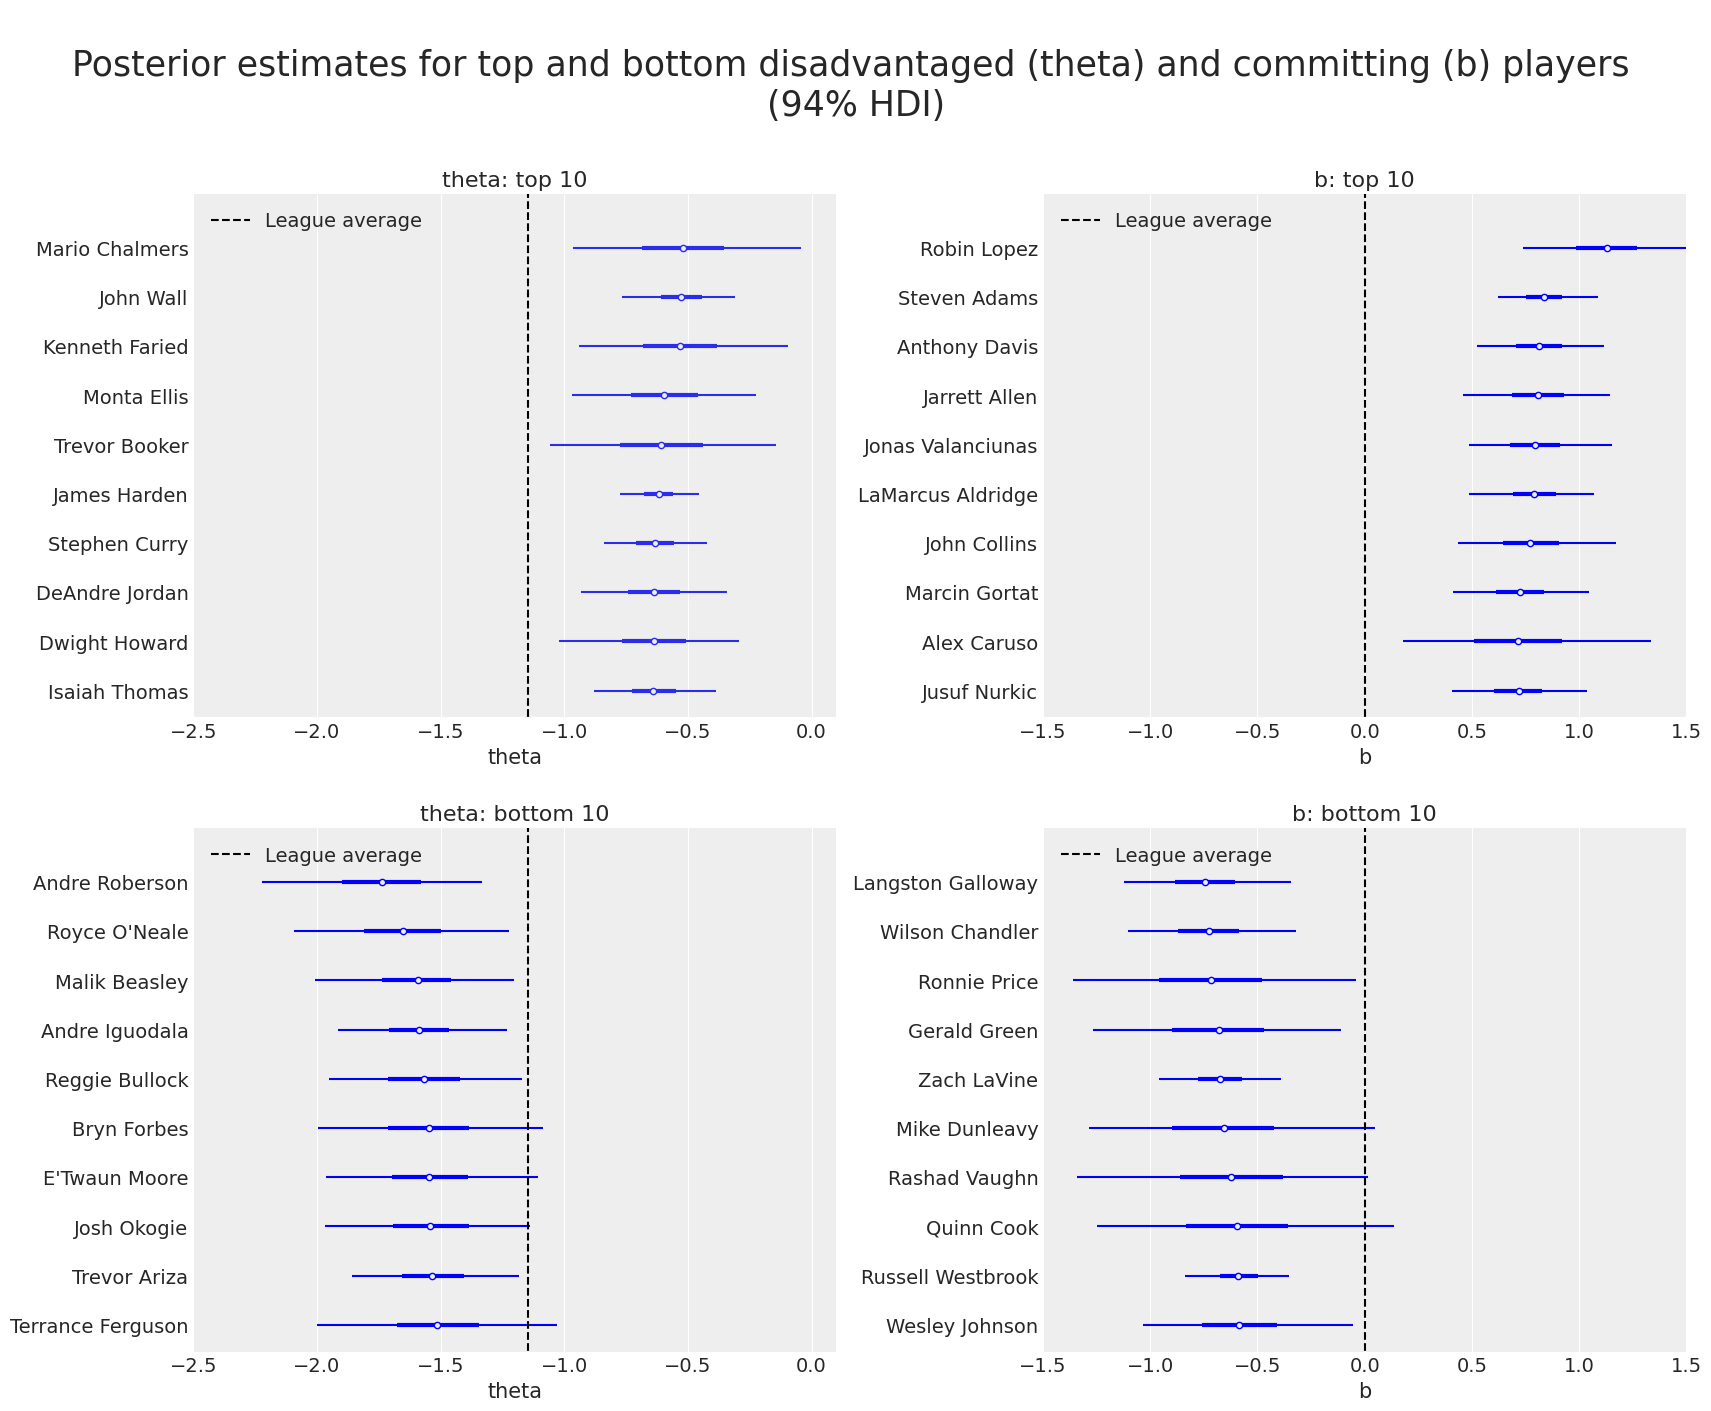

In [14]:
def order_posterior(inferencedata, var, bottom_bool):
    xarray_ = inferencedata.posterior[var].mean(dim=["chain", "draw"])
    return xarray_.sortby(xarray_, ascending=bottom_bool)

top_theta, bottom_theta = (
    order_posterior(trace, "theta", False),
    order_posterior(trace, "theta", True),
)
top_b, bottom_b = (order_posterior(trace, "b", False), order_posterior(trace, "b", True))

amount = 10

fig = plt.figure(figsize=(17, 14))
fig.suptitle(
    "\nPosterior estimates for top and bottom disadvantaged (theta) and "
    "committing (b) players \n(94% HDI)\n",
    fontsize=25,
)
theta_top_ax = fig.add_subplot(221)
b_top_ax = fig.add_subplot(222)
theta_bottom_ax = fig.add_subplot(223, sharex=theta_top_ax)
b_bottom_ax = fig.add_subplot(224, sharex=b_top_ax)

az.plot_forest(
    trace,
    var_names=["theta"],
    combined=True,
    coords={"disadvantaged": top_theta["disadvantaged"][:amount]},
    ax=theta_top_ax,
    labeller=az.labels.NoVarLabeller(),
)
theta_top_ax.set_title(f"theta: top {amount}")
theta_top_ax.set_xlabel("theta\n")
theta_top_ax.set_xlim(xmin=-2.5, xmax=0.1)
theta_top_ax.vlines(mu_theta_mean, -1, amount, "k", "--", label=("League average"))
theta_top_ax.legend(loc=2)

az.plot_forest(
    trace,
    var_names=["theta"],
    colors="blue",
    combined=True,
    coords={"disadvantaged": bottom_theta["disadvantaged"][:amount]},
    ax=theta_bottom_ax,
    labeller=az.labels.NoVarLabeller(),
)
theta_bottom_ax.set_title(f"theta: bottom {amount}")
theta_bottom_ax.set_xlabel("theta")
theta_bottom_ax.vlines(mu_theta_mean, -1, amount, "k", "--", label=("League average"))
theta_bottom_ax.legend(loc=2)

az.plot_forest(
    trace,
    var_names=["b"],
    colors="blue",
    combined=True,
    coords={"committing": top_b["committing"][:amount]},
    ax=b_top_ax,
    labeller=az.labels.NoVarLabeller(),
)
b_top_ax.set_title(f"b: top {amount}")
b_top_ax.set_xlabel("b\n")
b_top_ax.set_xlim(xmin=-1.5, xmax=1.5)
b_top_ax.vlines(0, -1, amount, "k", "--", label="League average")
b_top_ax.legend(loc=2)

az.plot_forest(
    trace,
    var_names=["b"],
    colors="blue",
    combined=True,
    coords={"committing": bottom_b["committing"][:amount]},
    ax=b_bottom_ax,
    labeller=az.labels.NoVarLabeller(),
)
b_bottom_ax.set_title(f"b: bottom {amount}")
b_bottom_ax.set_xlabel("b")
b_bottom_ax.vlines(0, -1, amount, "k", "--", label="League average")
b_bottom_ax.legend(loc=2)
plt.show()

## Discovering Extra Hierarchical Structure

We explore whether top players in one skill are also top in the other, and analyze the role of player positions.

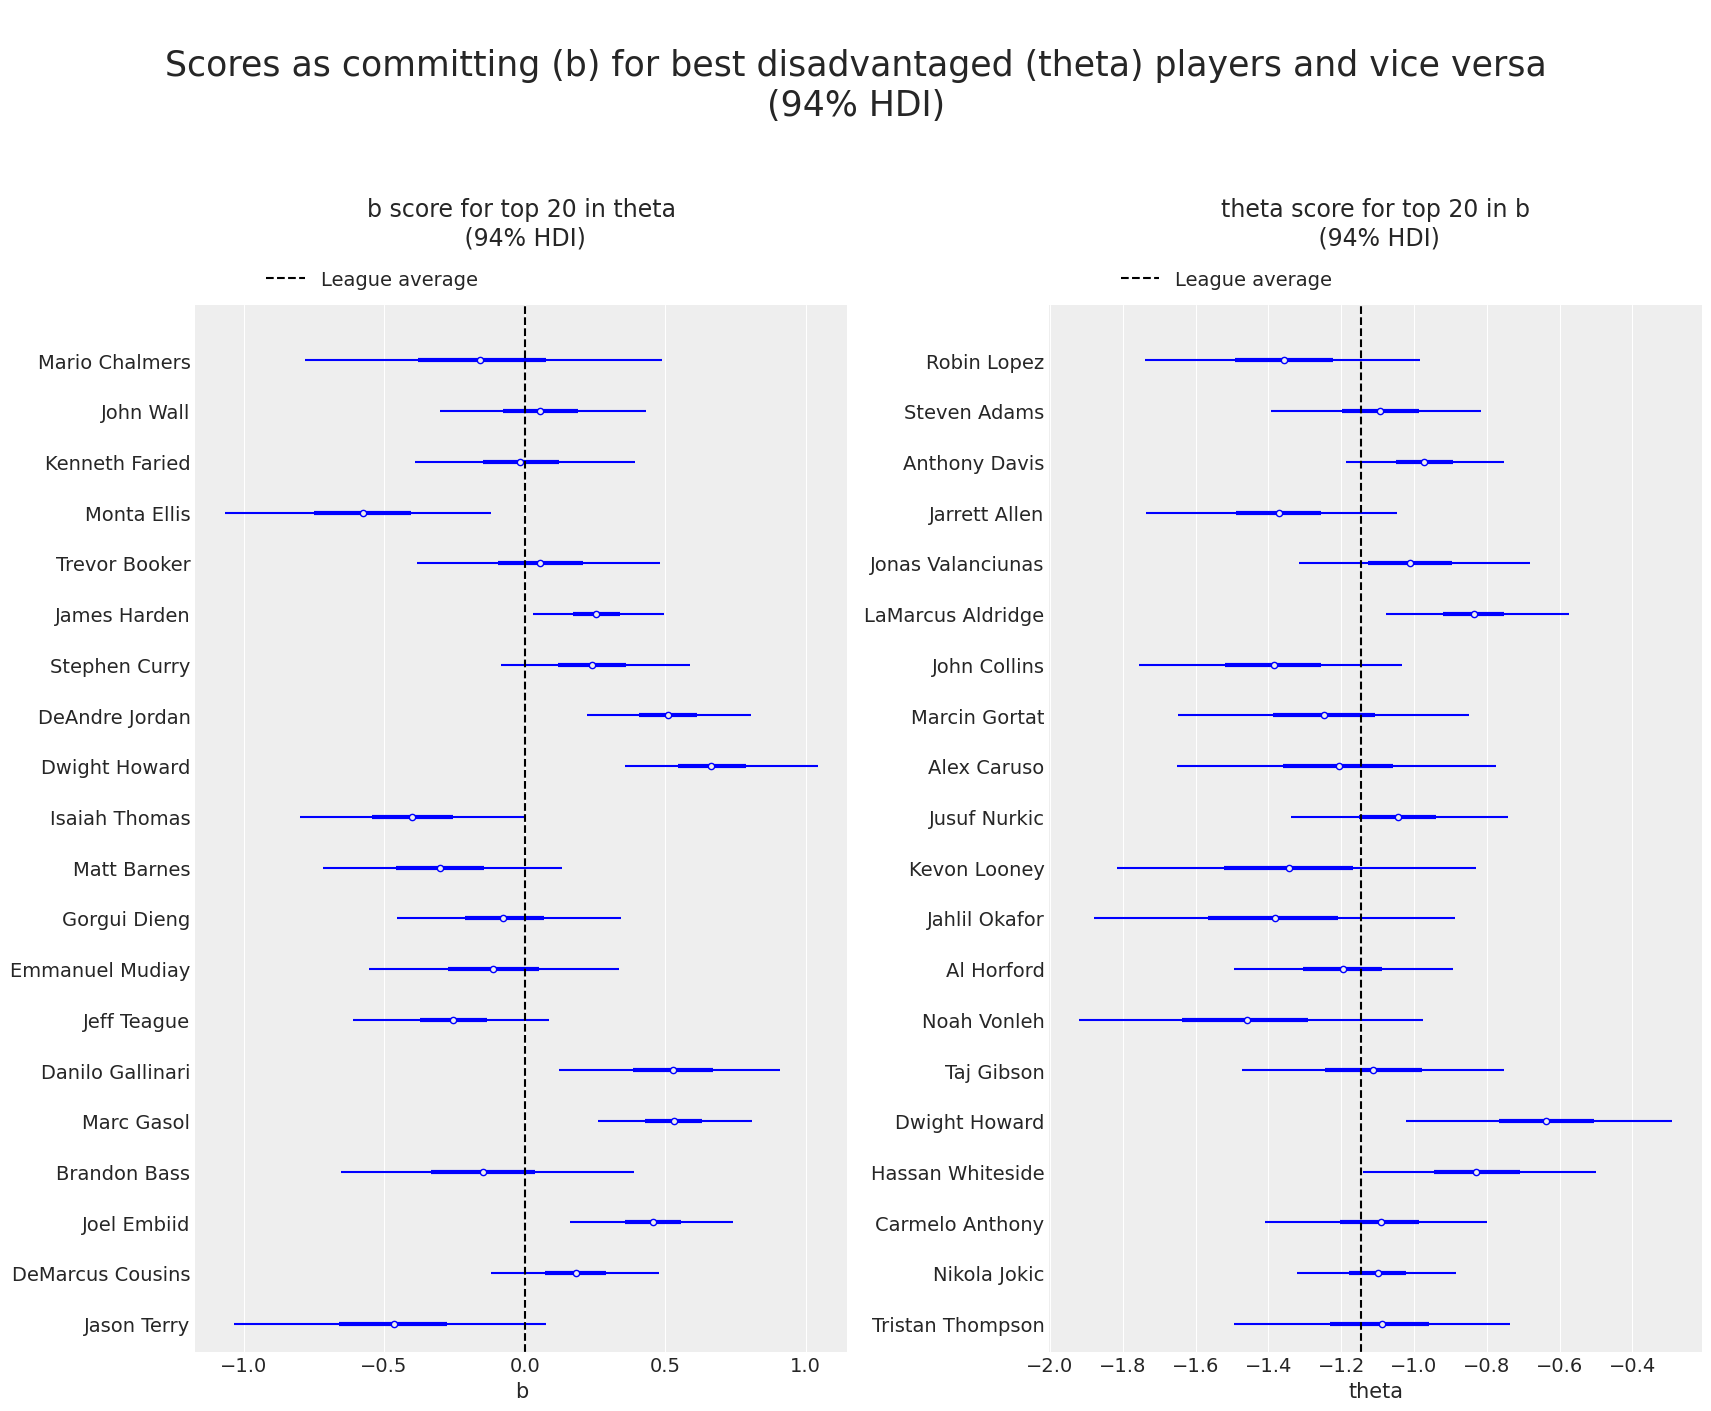

In [15]:
amount = 20
top_theta_players = top_theta["disadvantaged"][:amount].values
top_b_players = top_b["committing"][:amount].values

top_theta_in_committing = set(committing).intersection(set(top_theta_players))
top_b_in_disadvantaged = set(disadvantaged).intersection(set(top_b_players))
if (len(top_theta_in_committing) < amount) | (len(top_b_in_disadvantaged) < amount):
    print(
        f"Some players in the top {amount} for theta (or b) do not have observations for b (or theta).\n",
        "Plot not shown",
    )
else:
    fig = plt.figure(figsize=(17, 14))
    fig.suptitle(
        "\nScores as committing (b) for best disadvantaged (theta) players"
        " and vice versa"
        "\n(94% HDI)\n",
        fontsize=25,
    )
    b_top_theta = fig.add_subplot(121)
    theta_top_b = fig.add_subplot(122)

    az.plot_forest(
        trace,
        var_names=["b"],
        colors="blue",
        combined=True,
        coords={"committing": top_theta_players},
        figsize=(7, 7),
        ax=b_top_theta,
        labeller=az.labels.NoVarLabeller(),
    )
    b_top_theta.set_title(f"\nb score for top {amount} in theta\n (94% HDI)\n\n", fontsize=17)
    b_top_theta.set_xlabel("b")
    b_top_theta.vlines(mu_b_mean, -1, amount, color="k", ls="--", label="League average")
    b_top_theta.legend(loc="upper right", bbox_to_anchor=(0.46, 1.05))

    az.plot_forest(
        trace,
        var_names=["theta"],
        colors="blue",
        combined=True,
        coords={"disadvantaged": top_b_players},
        figsize=(7, 7),
        ax=theta_top_b,
        labeller=az.labels.NoVarLabeller(),
    )
    theta_top_b.set_title(f"\ntheta score for top {amount} in b\n (94% HDI)\n\n", fontsize=17)
    theta_top_b.set_xlabel("theta")
    theta_top_b.vlines(mu_theta_mean, -1, amount, color="k", ls="--", label="League average")
    theta_top_b.legend(loc="upper right", bbox_to_anchor=(0.46, 1.05));

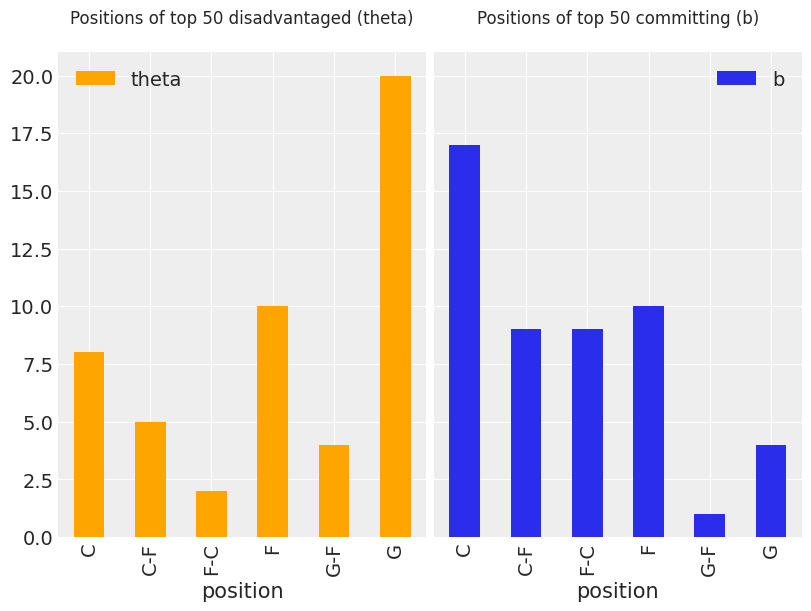

In [16]:
amount = 50
top_theta_players = top_theta["disadvantaged"][:amount].values
top_b_players = top_b["committing"][:amount].values

positions = ["C", "C-F", "F-C", "F", "G-F", "G"]

fig = plt.figure(figsize=(8, 6))
top_theta_position = fig.add_subplot(121)
df_position.loc[df_position.index.isin(top_theta_players)].position.value_counts().loc[
    positions
].plot.bar(ax=top_theta_position, color="orange", label="theta")
top_theta_position.set_title(f"Positions of top {amount} disadvantaged (theta)\n", fontsize=12)
top_theta_position.legend(loc="upper left")

top_b_position = fig.add_subplot(122, sharey=top_theta_position)
df_position.loc[df_position.index.isin(top_b_players)].position.value_counts().loc[
    positions
].plot.bar(ax=top_b_position, label="b")
top_b_position.set_title(f"Positions of top {amount} committing (b)\n", fontsize=12)
top_b_position.legend(loc="upper right");

## References

Jean-Paul Fox. Bayesian item response modeling: Theory and applications. Springer, 2010.

Austin Rochford , Lorenzo Toniazzi . "NBA Foul Analysis with Item Response Theory". In: PyMC Examples. Ed. by PyMC Team. DOI: 10.5281/zenodo.5654871